## Model Evaluation Pipeline

models to consider for evaluation:

1. Dummy Classifier (for base)
2. Logistic Regression
3. Random Forest
4. XGBoosting


### Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn. metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score, average_precision_score

import warnings
warnings.filterwarnings('ignore')

# setting for printing all dataframe columns
pd.set_option('display.max_columns', None)

In [3]:
# load traning dataset
df = pd.read_csv('../../data/processed/train_phl.csv')
df.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_MASS,P_MASS_ORIGIN,P_RADIUS,P_PERIOD,P_SEMI_MAJOR_AXIS,P_ECCENTRICITY,P_INCLINATION,P_OMEGA,S_NAME,S_TYPE,S_MAG,S_DISTANCE,S_TEMPERATURE,S_MASS,S_RADIUS,S_METALLICITY,S_AGE,S_LOG_LUM,S_LOG_G,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_TEMP_EQUIL,P_TEMP_SURF,P_TYPE,S_TYPE_TEMP,S_LUMINOSITY,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,HABITABILITY
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,250.0000,Mass,13.90,NaN,3.4000,NaN,NaN,NaN,OGLE-2016-BLG-1227L,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,4.240945,17.985612,1.293929,0.093088,0.461577,3.400000,3.400000,3.400000,3.400000,NaN,NaN,NaN,Jovian,NaN,NaN,NaN,NaN,0.214133,0,0,NaN,0,NaN,0
1,Kepler-829 b,Transit,Kepler,2016,5.1000,M-R relationship,2.11,6.883376,0.0678,0.0000,89.82,NaN,Kepler-829,NaN,14.973,1073.7600,5698.0,0.98,0.97,0.03,4.68,0.040,4.46,1.554690,2.417062,1.145527,0.542904,0.001175,0.067800,0.067800,0.067800,0.067800,238.52868,1001.11710,1130.6044,Superterran,G,1.096478,2.827247,1.756317,0.459559,0,0,Hot,0,0.254763,0
2,K2-283 b,Transit,K2,2018,12.2000,M-R relationship,3.52,1.921036,0.0291,NaN,NaN,NaN,K2-283,NaN,14.364,402.9150,5060.0,0.89,0.82,0.28,NaN,-0.524,4.56,1.861695,3.465909,0.984633,0.279725,0.000697,0.029100,0.029100,0.029100,0.029100,353.35726,1104.46820,NaN,Neptunian,K,0.299226,1.476943,0.568374,0.443760,0,0,Hot,0,0.193906,0
3,TOI-1260 c,Transit,Transiting Exoplanet Survey Satellite (TESS),2021,13.2000,Mass,2.76,7.493134,0.0657,0.0000,87.97,0.0,TOI-1260,K6 V,11.922,73.5977,4227.0,0.68,0.67,-0.10,6.70,-0.889,4.57,2.186918,4.782609,1.732829,0.627837,0.001766,0.065700,0.065700,0.065700,0.065700,29.91364,595.75408,NaN,Neptunian,K,0.129122,0.970206,0.124210,0.431924,0,0,Hot,0,0.260440,0
4,HD 149143 b,Radial Velocity,Haute-Provence Observatory,2005,422.7139,Msini,13.60,4.071820,0.0530,0.0167,NaN,217.0,HD 149143,G0,7.890,73.2801,5856.0,1.20,1.44,0.29,4.28,0.350,4.25,5.575115,31.081904,2.285434,0.168047,0.003682,0.053007,0.052115,0.053885,0.053002,797.09270,1353.48740,NaN,Jovian,G,2.238721,4.039836,2.464949,0.484387,0,0,Hot,0,0.067319,0


In [4]:
df.shape

(3755, 47)

In [5]:
# configure features, target and group

features = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_ECCENTRICITY', 
            'S_MASS', 'S_RADIUS', 'S_TEMPERATURE', 
            'S_METALLICITY', 'P_TEMP_SURF', 'S_DISTANCE']
# Removed feature due to possible information leakage: 'P_ESI'

target = 'HABITABILITY'
group_col = 'S_NAME'

n_splits = 5
random_state = 42

In [6]:
df[features].shape

(3755, 10)

In [7]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   P_MASS          3749 non-null   float64
 1   P_RADIUS        3749 non-null   float64
 2   P_PERIOD        3588 non-null   float64
 3   P_ECCENTRICITY  3217 non-null   float64
 4   S_MASS          3752 non-null   float64
 5   S_RADIUS        3603 non-null   float64
 6   S_TEMPERATURE   3609 non-null   float64
 7   S_METALLICITY   3456 non-null   float64
 8   P_TEMP_SURF     1626 non-null   float64
 9   S_DISTANCE      3742 non-null   float64
dtypes: float64(10)
memory usage: 293.5 KB


no 'object' in the list of features.

In [8]:
missing_val = df[features + [target]].isnull().sum().sort_values(ascending=False)
print("Missing values in each column:")
print(missing_val)

Missing values in each column:
P_TEMP_SURF       2129
P_ECCENTRICITY     538
S_METALLICITY      299
P_PERIOD           167
S_RADIUS           152
S_TEMPERATURE      146
S_DISTANCE          13
P_MASS               6
P_RADIUS             6
S_MASS               3
HABITABILITY         0
dtype: int64


In [9]:
# calaculate percentage of missing values
missing_percentage = (missing_val / len(df)) * 100
print("\nPercentage of missing values in each column:")
print(missing_percentage)


Percentage of missing values in each column:
P_TEMP_SURF       56.697736
P_ECCENTRICITY    14.327563
S_METALLICITY      7.962716
P_PERIOD           4.447403
S_RADIUS           4.047936
S_TEMPERATURE      3.888149
S_DISTANCE         0.346205
P_MASS             0.159787
P_RADIUS           0.159787
S_MASS             0.079893
HABITABILITY       0.000000
dtype: float64


### Pre-Processing and Basic Model Evaluation

In [10]:
X = df[features].copy()
y = df[target].copy()
groups = df[group_col].copy()

# impute numerical missing values with KNNImputer
numerical_features = df[features].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')

# define models to evaluate
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(random_state=random_state, class_weight='balanced'))
    ]),
    'RandomForestClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
    ]),
    'XGBClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

results = {m: [] for m in models.keys()}

metrics = {
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
    'recall': recall_score,
    'precision': precision_score, 
    'pr_auc': average_precision_score
}

for train_idx, test_idx in sgkf.split(X, y, groups):
    X_tt, X_ho = X.iloc[train_idx], X.iloc[test_idx]
    y_tt, y_ho = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        model.fit(X_tt, y_tt)
        y_pred = model.predict(X_ho)

        fold_metrics = {
            metric_name: metric_func(y_ho, y_pred)
            for metric_name, metric_func in metrics.items()
        }

        try:
            y_prob = model.predict_proba(X_ho)[:, 1]
            fold_metrics['roc_auc'] = roc_auc_score(y_ho, y_prob)
            fold_metrics['pr_auc'] = average_precision_score(y_ho, y_prob)
        except:
            fold_metrics['roc_auc'] = np.nan
            fold_metrics['pr_auc'] = np.nan
        results[model_name].append(fold_metrics)

summary = {}

for model_name, fold in results.items():
    df_model = pd.DataFrame(fold)
    summary[model_name] = df_model.mean().round(4)
summary_df = pd.DataFrame(summary).T

summary_df

,f1_score,roc_auc,recall,precision,pr_auc
Dummy,0.0000,0.5000,0.0000,0.0000,0.0136
Logistic Regression,0.4741,0.9978,1.0000,0.3159,0.7768
RandomForestClassifier,0.8733,0.9929,0.8073,0.9636,0.9696
XGBClassifier,0.8764,0.9954,0.8648,0.9116,0.9391


The feature importance calculation demonstrates that 'P_TEMP_SURF' has the highest feature importance for the Random Forest model. 
We need to know how the 'P_TEMP_SURF' is calculated. Is it calculated using habitability label? if yes, it is possibly causing data leakage.

In [11]:
print('P_TEMP_SURF statistics by habitability class:')
print(df.groupby('HABITABILITY')['P_TEMP_SURF'].describe())

P_TEMP_SURF statistics by habitability class:
               count         mean         std        min         25%  \
HABITABILITY                                                           
0             1575.0  1000.464594  498.394178  144.92624  660.629760   
1               51.0   266.580769   33.884299  198.92846  238.083765   

                    50%         75%         max  
HABITABILITY                                     
0             944.48818  1229.22845  8125.49630  
1             270.03485   295.45185   325.36751  


In [12]:
print(f'\n Correlation of P_TEMP_SURF with HABITABILITY: {df["P_TEMP_SURF"].corr(df["HABITABILITY"])}')


 Correlation of P_TEMP_SURF with HABITABILITY: -0.25240110527191095


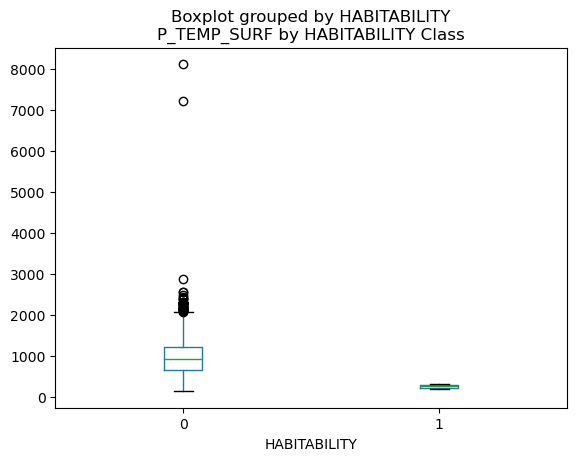

In [13]:
df.boxplot(column='P_TEMP_SURF', by='HABITABILITY', grid=False)
plt.title('P_TEMP_SURF by HABITABILITY Class')
plt.show()

In [14]:
# features without 'P_TENP_SURF'

features_without_p_temp_surf = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_ECCENTRICITY', 
            'S_MASS', 'S_RADIUS', 'S_TEMPERATURE', 'S_DISTANCE', 
            'S_METALLICITY']

target = 'HABITABILITY'
group_col = 'S_NAME'

n_splits = 5
random_state = 42

In [15]:
X = df[features_without_p_temp_surf].copy()
y = df[target].copy()
groups = df[group_col].copy()

# impute numerical missing values with KNNImputer
numerical_features = df[features_without_p_temp_surf].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')

# define models to evaluate
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(random_state=random_state, class_weight='balanced'))
    ]),
    'RandomForestClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
    ]),
    'XGBClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

results = {m: [] for m in models.keys()}

metrics = {
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
    'recall': recall_score,
    'precision': precision_score, 
    'pr_auc': average_precision_score
}

for train_idx, test_idx in sgkf.split(X, y, groups):
    X_tt, X_ho = X.iloc[train_idx], X.iloc[test_idx]
    y_tt, y_ho = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        model.fit(X_tt, y_tt)
        y_pred = model.predict(X_ho)

        fold_metrics = {
            metric_name: metric_func(y_ho, y_pred)
            for metric_name, metric_func in metrics.items()
        }

        try:
            y_prob = model.predict_proba(X_ho)[:, 1]
            fold_metrics['roc_auc'] = roc_auc_score(y_ho, y_prob)
            fold_metrics['pr_auc'] = average_precision_score(y_ho, y_prob)
        except:
            fold_metrics['roc_auc'] = np.nan
            fold_metrics['pr_auc'] = np.nan
        results[model_name].append(fold_metrics)

summary = {}

for model_name, fold in results.items():
    df_model = pd.DataFrame(fold)
    summary[model_name] = df_model.mean().round(4)
summary_df = pd.DataFrame(summary).T

summary_df

,f1_score,roc_auc,recall,precision,pr_auc
Dummy,0.0000,0.5000,0.0000,0.0000,0.0136
Logistic Regression,0.1696,0.9469,0.8822,0.0953,0.3548
RandomForestClassifier,0.3367,0.9904,0.2352,0.6800,0.6838
XGBClassifier,0.4233,0.9874,0.3216,0.6476,0.6148


F1 scores results without the P_TEMP_SURF' drops significantly, demonstrating that this feature is the primary predictor of the habitability. The reason is that the surface temperature of the planet directly depends on the exsitance of liquid water on the surface of the planet. 

So the problem is not learnable without the surface temp. 
Looking into the NASA's exoplanets database, it seems like the planet's surface temperature is not among the primary measured features. instead we have the planets equilibrium temperature. Given that there might be a possibility of the planet surface temp being calculated from the habitibaility label, it is better to replace it with the equilibrium temperature. 

In [16]:
# features with 'P_TEMP_EQUIL'

features_with_equil_temp = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_ECCENTRICITY', 
            'S_MASS', 'S_RADIUS', 'S_TEMPERATURE', 'S_DISTANCE', 
            'S_METALLICITY', 'P_TEMP_EQUIL']

target = 'HABITABILITY'
group_col = 'S_NAME'

n_splits = 5
random_state = 42

# impute numerical missing values with KNNImputer
numerical_features = df[features_with_equil_temp].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')


X = df[features_with_equil_temp].copy()
y = df[target].copy()
groups = df[group_col].copy()

# define models to evaluate
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(random_state=random_state, class_weight='balanced'))
    ]),
    'RandomForestClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
    ]),
    'XGBClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

results = {m: [] for m in models.keys()}

metrics = {
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
    'recall': recall_score,
    'precision': precision_score, 
    'pr_auc': average_precision_score
}

for train_idx, test_idx in sgkf.split(X, y, groups):
    X_tt, X_ho = X.iloc[train_idx], X.iloc[test_idx]
    y_tt, y_ho = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        model.fit(X_tt, y_tt)
        y_pred = model.predict(X_ho)

        fold_metrics = {
            metric_name: metric_func(y_ho, y_pred)
            for metric_name, metric_func in metrics.items()
        }

        try:
            y_prob = model.predict_proba(X_ho)[:, 1]
            fold_metrics['roc_auc'] = roc_auc_score(y_ho, y_prob)
            fold_metrics['pr_auc'] = average_precision_score(y_ho, y_prob)
        except:
            fold_metrics['roc_auc'] = np.nan
            fold_metrics['pr_auc'] = np.nan
        results[model_name].append(fold_metrics)

summary = {}

for model_name, fold in results.items():
    df_model = pd.DataFrame(fold)
    summary[model_name] = df_model.mean().round(4)
summary_df = pd.DataFrame(summary).T

summary_df

,f1_score,roc_auc,recall,precision,pr_auc
Dummy,0.0000,0.5000,0.0000,0.0000,0.0136
Logistic Regression,0.4205,0.9961,1.0000,0.2711,0.6839
RandomForestClassifier,0.8727,0.9928,0.7940,0.9800,0.9580
XGBClassifier,0.9009,0.9983,0.9333,0.8939,0.9729


More reasonable scores for this case. Lets now try to include some engineered features from the database and look at the results.

In [18]:
# Or we can evalute the models using engineered features
engineered_features = ['P_ECCENTRICITY', 'P_SEMI_MAJOR_AXIS',
                       'S_MASS', 'S_TEMPERATURE', 
                       'S_METALLICITY', 'P_MASS', 'P_RADIUS',
                       'P_GRAVITY','P_FLUX', 'S_LUMINOSITY', 
                       'S_DISTANCE', 'S_TIDAL_LOCK']
# 'P_HABZONE_CON'
target = 'HABITABILITY'
group_col = 'S_NAME'

n_splits = 5
random_state = 42

# impute numerical missing values with KNNImputer
numerical_features = df[engineered_features].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')


X = df[engineered_features].copy()
y = df[target].copy()
groups = df[group_col].copy()

# define models to evaluate
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(random_state=random_state, class_weight='balanced'))
    ]),
    'RandomForestClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
    ]),
    'XGBClassifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

results = {m: [] for m in models.keys()}

metrics = {
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
    'recall': recall_score,
    'precision': precision_score, 
    'pr_auc': average_precision_score
}

for train_idx, test_idx in sgkf.split(X, y, groups):
    X_tt, X_ho = X.iloc[train_idx], X.iloc[test_idx]
    y_tt, y_ho = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        model.fit(X_tt, y_tt)
        y_pred = model.predict(X_ho)

        fold_metrics = {
            metric_name: metric_func(y_ho, y_pred)
            for metric_name, metric_func in metrics.items()
        }

        try:
            y_prob = model.predict_proba(X_ho)[:, 1]
            fold_metrics['roc_auc'] = roc_auc_score(y_ho, y_prob)
            fold_metrics['pr_auc'] = average_precision_score(y_ho, y_prob)
        except:
            fold_metrics['roc_auc'] = np.nan
            fold_metrics['pr_auc'] = np.nan
        results[model_name].append(fold_metrics)

summary = {}

for model_name, fold in results.items():
    df_model = pd.DataFrame(fold)
    summary[model_name] = df_model.mean().round(4)
summary_df = pd.DataFrame(summary).T

summary_df

,f1_score,roc_auc,recall,precision,pr_auc
Dummy,0.0000,0.5000,0.0000,0.0000,0.0136
Logistic Regression,0.1714,0.9375,0.8822,0.0964,0.3377
RandomForestClassifier,0.8233,0.9993,0.7346,0.9818,0.9659
XGBClassifier,0.8868,0.9975,0.8914,0.8967,0.9529


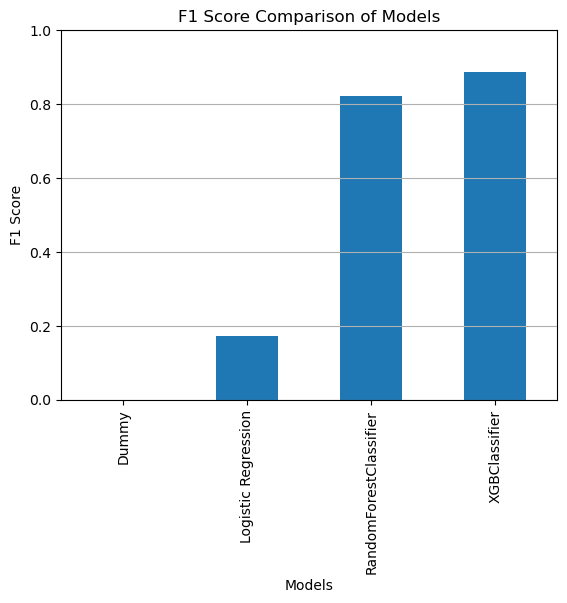

In [94]:
# plot f1 score comparison
summary_df['f1_score'].plot(kind='bar', title='F1 Score Comparison of Models', ylabel='F1 Score', xlabel='Models', legend=False)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

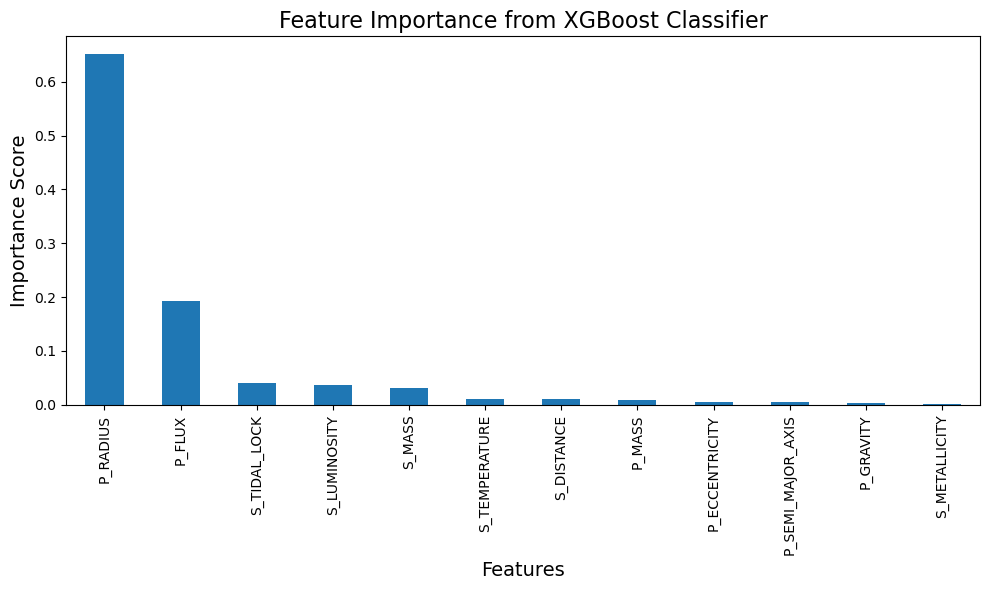

In [79]:
#Feature importance using XGBoost
xgb_model = XGBClassifier(random_state=random_state)
xgb_model.fit(X, y)
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(10,6))
plt.title('Feature Importance from XGBoost Classifier', fontsize=16)
plt.ylabel('Importance Score', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.tight_layout()
plt.show() 

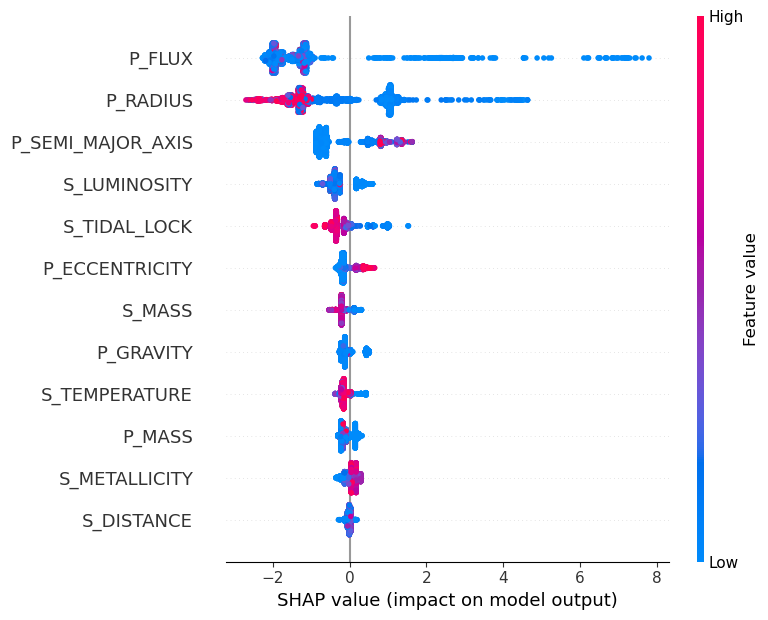

In [80]:
import shap

# Prepare data
X_processed = models['XGBClassifier'].named_steps['preprocessor'].transform(X)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_processed)

# Summary plot
shap.summary_plot(shap_values, X_processed, feature_names=engineered_features)

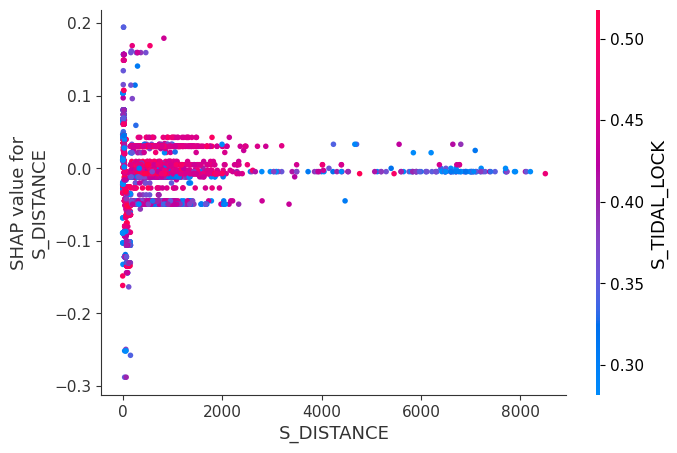

In [81]:
shap.dependence_plot("S_DISTANCE", shap_values, X_processed, feature_names=engineered_features)

In [19]:
# Test on specific cases that should be obvious
test_cases = {
    'Earth-like': {
        'P_MASS': 1.0,  # Earth masses
        'P_RADIUS': 1.0,  # Earth radii
        'P_FLUX': 1.0,  # Earth-equivalent flux
        #'P_HABZONE_CON': 1.0,  # In habitable zone
        'P_ECCENTRICITY': 0.0167,
        'S_MASS': 1.0,
        'S_TEMPERATURE': 5778,
        'S_DISTANCE': 1.0,
        'S_METALLICITY': 0.0,
        'S_LUMINOSITY': 1.0,
        'P_SEMI_MAJOR_AXIS': 1.0,
        'P_GRAVITY': 1.0,
        'S_TIDAL_LOCK': 0,
        'Expected': 'HABITABLE'
    },
    'Hot Jupiter': {
        'P_MASS': 300,  # Jupiter-like
        'P_FLUX': 100,  # Very close to star
        'P_RADIUS': 11.2,  # Jupiter radii
        #'P_HABZONE_CON': 0.0,  # Not in habitable zone
        'P_ECCENTRICITY': 0.0489,
        'S_MASS': 1.0,
        'S_TEMPERATURE': 5778,
        'S_DISTANCE': 1.0,
        'S_METALLICITY': 0.0,
        'S_LUMINOSITY': 1.0,
        'P_SEMI_MAJOR_AXIS': 0.05,
        'P_GRAVITY': 2.5,
        'S_TIDAL_LOCK': 1,
        'Expected': 'NON-HABITABLE'
    }
}

# Make predictions and verify they make sense
for case_name, case_data in test_cases.items():
    # Create DataFrame for prediction
    X_test_case = pd.DataFrame([case_data])
    pred = models['XGBClassifier'].predict_proba(X_test_case)[:, 1]
    print(f"{case_name}: {pred[0]:.3f} (Expected: {case_data['Expected']})")

Earth-like: 0.996 (Expected: HABITABLE)
Hot Jupiter: 0.000 (Expected: NON-HABITABLE)


Given that we are not sure how the Habitable zone (conditional) was calculated we prefer to eliminate it from the features. even though the correlation between this feature and the probability is about 0.51 and removing it from the features does not drop the results by alot.

## Hyper_Parameter Tuning

In [22]:
final_features = engineered_features

target = 'HABITABILITY'
group_col = 'S_NAME'

random_state = 42

# parameters
param_distributions = {
    'classifier__n_estimators': [200, 250,300, 350, 400],
    'classifier__max_depth': [4, 5, 6, 7],
    'classifier__learning_rate': [0.05, 0.07, 0.1, 0.12],
    'classifier__min_child_weight': [1, 2, 3, 5],
    'classifier__scale_pos_weight': [3, 3.5, 4, 4.5],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0, 0.05, 0.1, 0.2],
    'classifier__reg_alpha': [0, 0.01, 0.1, 0.5],
    'classifier__reg_lambda': [0.5, 1, 1.5, 2]
}

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=random_state, eval_metric='logloss', tree_method='hist'))
])

# impute numerical missing values with KNNImputer
numerical_features = df[engineered_features].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')


X = df[engineered_features].copy()
y = df[target].copy()
groups = df[group_col].copy()

outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
inner_cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=random_state)

inner_search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='f1',
    cv=inner_cv,
    verbose=1,
    n_jobs=-1,
    random_state=random_state
)

#metrics for evaluation
roc_aus_scores=[]
f1_scores=[]
recall_scores = []
pr_auc_scores = []


# Outer CV Loop
for train_idx, test_idx in outer_cv.split(X, y, groups=groups):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
    outer_train_groups = groups.iloc[train_idx]

    #inner search for hyperparameter tunning
    inner_search.fit(X_train_outer, y_train_outer, groups=outer_train_groups)

    # eval the best model on the outer group
    best_model = inner_search.best_estimator_
    preds = best_model.predict(X_test_outer)
    probs = best_model.predict_proba(X_test_outer)[:, 1]

    #scores
    roc_aus_scores.append(roc_auc_score(y_test_outer, probs))
    f1_scores.append(f1_score(y_test_outer, preds))
    recall_scores.append(recall_score(y_test_outer, preds))
    pr_auc_scores.append(average_precision_score(y_test_outer, preds))

# Average scores
print(f'ROC_AUC Score: {np.mean(roc_aus_scores):.4f}')
print(f'F1 Score: {np.mean(f1_scores):.4f}')
print(f'Recall Score: {np.mean(recall_scores): .4f}')
print(f'Balanced Accuracy Score: {np.mean(pr_auc_scores): .4f}')

print('\n Best hyper_parameters:')
print(inner_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
ROC_AUC Score: 0.9979
F1 Score: 0.8532
Recall Score:  0.8629
Balanced Accuracy Score:  0.7393

 Best hyper_parameters:
{'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 4, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 0.5, 'classifier__n_estimators': 400, 'classifier__min_child_weight': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.9}


In [24]:
# Final model training

best_params = {
    'n_estimators': 300, #400,
    'max_depth': 4,#5,
    'learning_rate': 0.05,#0.1,
    'min_child_weight': 3, #1,
    'subsample': 0.7, #0.8,
    'colsample_bytree': 0.7,#0.9,
    'gamma': 0.1, #0
    'reg_alpha': 1.0, #0.5,
    'reg_lambda': 3, #2,
    'scale_pos_weight': 4,
    'random_state': 42,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

engineered_features = ['P_ECCENTRICITY', 'P_SEMI_MAJOR_AXIS',
                       'S_MASS', 'S_TEMPERATURE', 'S_DISTANCE', 
                       'S_METALLICITY', 'P_MASS', 'P_RADIUS',
                       'P_GRAVITY','P_FLUX', 'S_LUMINOSITY',
                       'S_TIDAL_LOCK']

target = 'HABITABILITY'
group_col = 'S_NAME'

n_splits = 5
random_state = 42

# impute numerical missing values with KNNImputer
numerical_features = df[engineered_features].select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_transformer = KNNImputer(n_neighbors=5, weights='distance')

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features)
], remainder='drop')

X = df[engineered_features].copy()
y = df[target].copy()
groups = df[group_col].copy()

final_model = Pipeline([
    ('preprocessor' , preprocessor),
    ('classifier', XGBClassifier(**best_params))
])

# Train on ALL data
final_model.fit(X, y)


y_pred = final_model.predict(X)
y_prob = final_model.predict_proba(X)[:, 1]

print('Final Model Classification Report on Training Data:')
print(f'f1_score: {f1_score(y, y_pred):.4f})')
print(f'roc_auc: {roc_auc_score(y, y_prob):.4f})')
print(f'recall: {recall_score(y, y_pred):.4f})')
print(f'precision: {precision_score(y, y_pred):.4f})')


Final Model Classification Report on Training Data:
f1_score: 0.9524)
roc_auc: 1.0000)
recall: 0.9804)
precision: 0.9259)


Fold 1 samples: 756
Fold 2 samples: 759
Fold 3 samples: 750
Fold 4 samples: 746
Fold 5 samples: 744
total samples evaluated: 3755


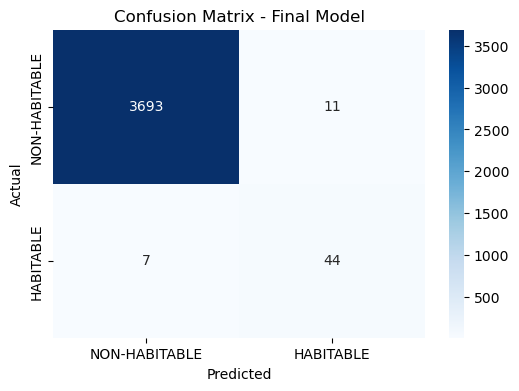

True Negatives:  3693 (correctly identified non-habitable)
False Positives: 11 (non-habitable predicted as habitable)
False Negatives: 7 (habitable predicted as non-habitable)
True Positives:  44 (correctly identified habitable)



In [25]:
# Confusion matrix analysis

y_all_true = []
y_all_pred = []
y_all_prob = []

outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups=groups), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    fold_model = Pipeline([
        ('preprocessor' , preprocessor),
        ('classifier', XGBClassifier(**best_params))
    ])

    fold_model.fit(X_train, y_train)
    y_prob = fold_model.predict_proba(X_test)[:, 1]
    y_pred = fold_model.predict(X_test)
    
    y_all_true.extend(y_test)
    y_all_prob.extend(y_prob)
    y_all_pred.extend(y_pred)

    print(f'Fold {fold} samples: {len(X_test)}')

y_all_true = np.array(y_all_true)
y_all_pred = np.array(y_all_pred)
y_all_prob = np.array(y_all_prob)

print(f'total samples evaluated: {len(y_all_true)}')

cm = confusion_matrix(y_all_true, y_all_pred)

fig, axes = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NON-HABITABLE', 'HABITABLE'], yticklabels=['NON-HABITABLE', 'HABITABLE'], ax=axes)
axes.set_ylabel('Actual')
axes.set_xlabel('Predicted')
axes.set_title('Confusion Matrix - Final Model')
plt.show()

tn, fp, fn, tp = cm.ravel()
metrics_text = (
    f"True Negatives:  {tn}\n"
    f"False Positives: {fp}\n"
    f"False Negatives: {fn}\n"
    f"True Positives:  {tp}\n\n"
    f"Recall:    {tp/(tp+fn):.3f}\n"
    f"Precision: {tp/(tp+fp):.3f}\n"
    f"F1-Score:  {f1_score(y_all_true, y_all_pred):.3f}"
)


print(f"True Negatives:  {tn} (correctly identified non-habitable)")
print(f"False Positives: {fp} (non-habitable predicted as habitable)")
print(f"False Negatives: {fn} (habitable predicted as non-habitable)")
print(f"True Positives:  {tp} (correctly identified habitable)\n")


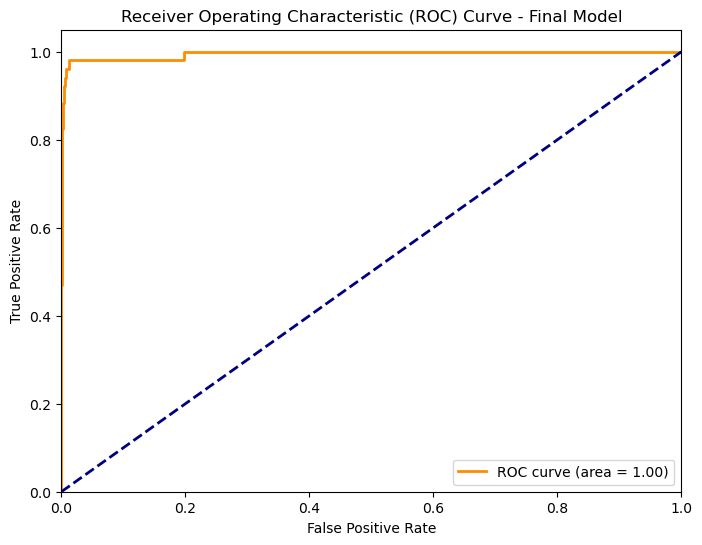

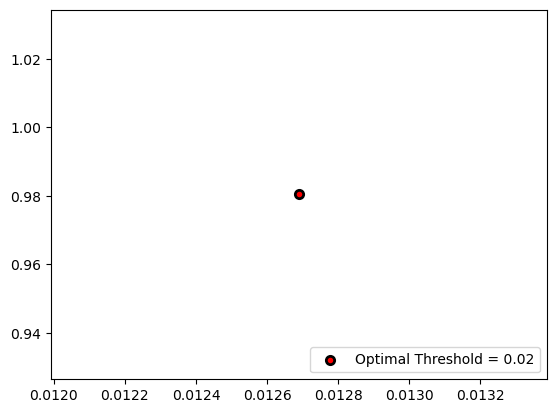

In [95]:
from sklearn.metrics import roc_curve, auc

# ROC-AUC Curve for final model
fpr, tpr, thresholds = roc_curve(y_all_true, y_all_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Final Model')
plt.legend(loc='lower right')
plt.show()

# optimal threshold 
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}',
            edgecolors='black',  linewidths=2)
plt.legend(loc='lower right')
plt.show()

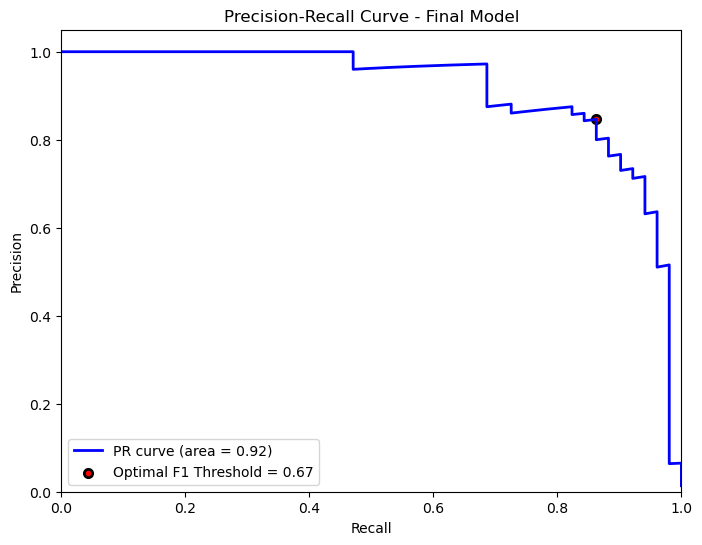

In [96]:
from sklearn.metrics import precision_recall_curve

# precision-recall curve for final model
precision, recall, thresholds = precision_recall_curve(y_all_true, y_all_prob)
pr_auc = average_precision_score(y_all_true, y_all_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_idx]

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Final Model')
plt.scatter(recall[optimal_f1_idx], precision[optimal_f1_idx], marker='o', color='red', label=f'Optimal F1 Threshold = {optimal_f1_threshold:.2f}',
            edgecolors='black',  linewidths=2)
plt.legend(loc='lower left')
plt.show()

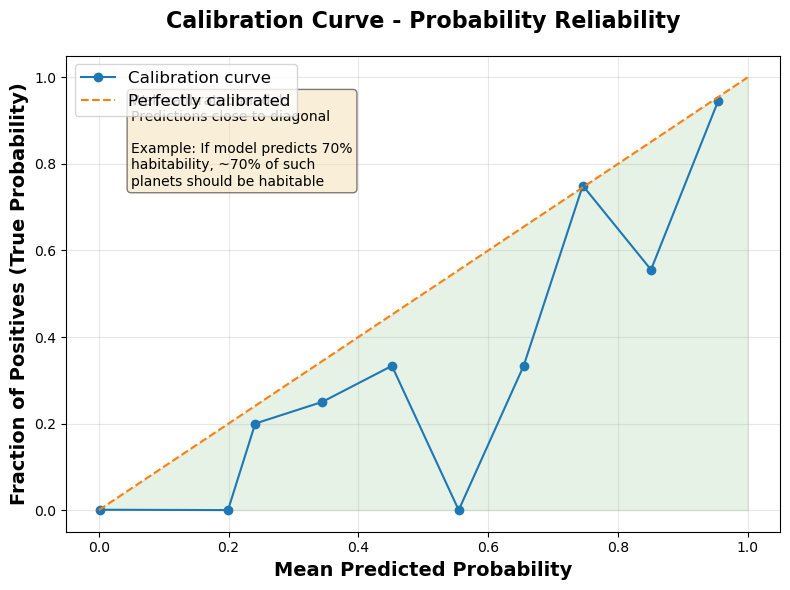

Mean Calibration Error: 0.1638
Consider isotonic calibration


In [28]:
# Callibration curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_all_true, y_all_prob, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Final Model')

plt.fill_between([0, 1], [0, 1], alpha=0.1, color='green')

plt.xlabel('Mean Predicted Probability', fontsize=14, fontweight='bold')
plt.ylabel('Fraction of Positives (True Probability)', fontsize=14, fontweight='bold')
plt.title('Calibration Curve - Probability Reliability', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.3)

# Add text explanation
calibration_text = (
    "Well-calibrated model:\n"
    "Predictions close to diagonal\n\n"
    "Example: If model predicts 70%\n"
    "habitability, ~70% of such\n"
    "planets should be habitable"
)
plt.text(0.05, 0.75, calibration_text, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Calculate calibration error
calibration_error = np.mean(np.abs(prob_true - prob_pred))
print(f"Mean Calibration Error: {calibration_error:.4f}")
if calibration_error < 0.05:
    print("Excellent calibration!")
elif calibration_error < 0.10:
    print("Good calibration")
else:
    print("Consider isotonic calibration")

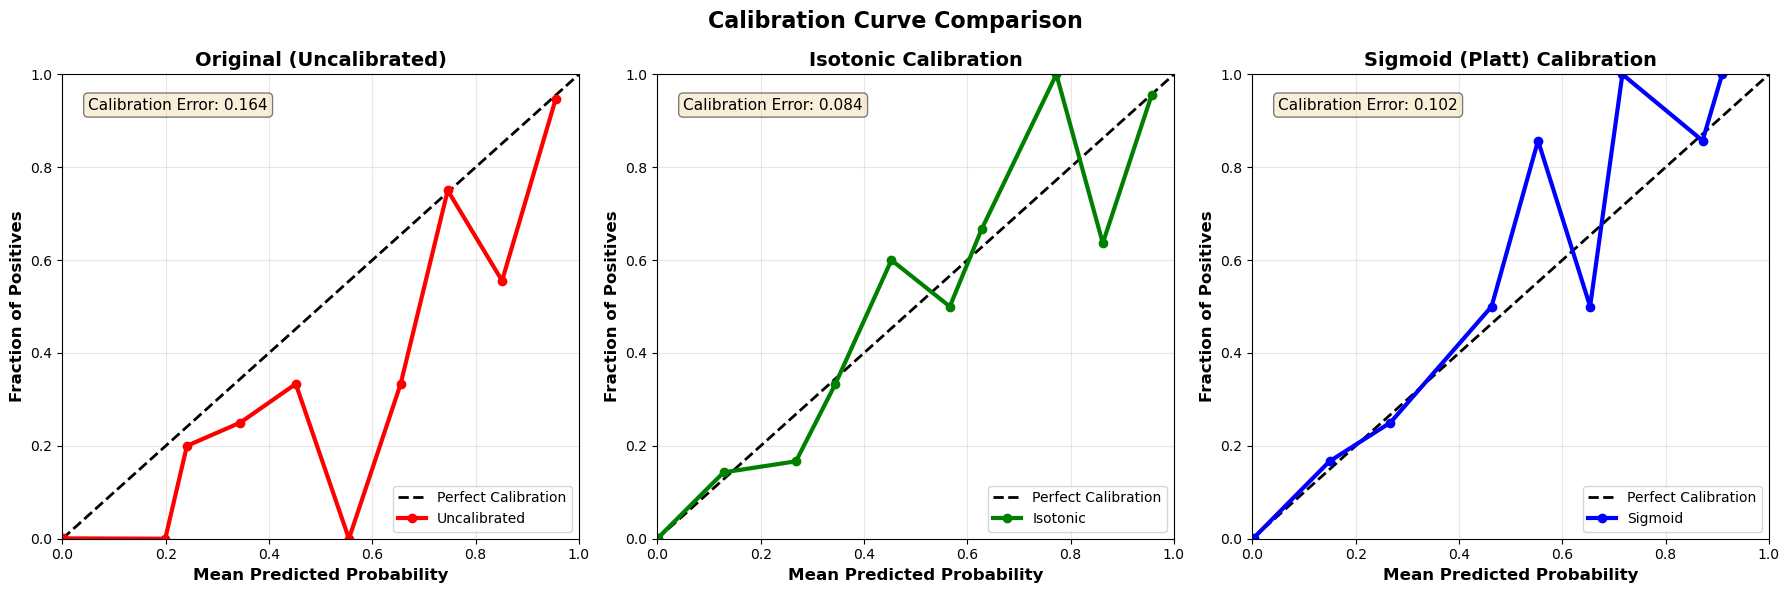


Calibration Errors:
  Uncalibrated:        0.1638
  Isotonic Calibrated: 0.0835
  Sigmoid Calibrated:  0.1021
Isotonic calibration IMPROVED by 0.0803


In [30]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# CALIBRATION COMPARISON

# Get uncalibrated predictions (from CV)
outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

uncalib_true = []
uncalib_pred = []
iso_calib_pred = []
sig_calib_pred = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups), 1):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
    # 1. Uncalibrated model
    uncalib_model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**best_params))
    ])
    uncalib_model.fit(X_train_fold, y_train_fold)
    prob_uncalib = uncalib_model.predict_proba(X_test_fold)[:, 1]
    
    # 2. Isotonic calibration
    iso_model = CalibratedClassifierCV(uncalib_model, method='isotonic', cv=3)
    iso_model.fit(X_train_fold, y_train_fold)
    prob_iso = iso_model.predict_proba(X_test_fold)[:, 1]
    
    # 3. Sigmoid calibration
    sig_model = CalibratedClassifierCV(uncalib_model, method='sigmoid', cv=3)
    sig_model.fit(X_train_fold, y_train_fold)
    prob_sig = sig_model.predict_proba(X_test_fold)[:, 1]
    
    # Collect
    uncalib_true.extend(y_test_fold)
    uncalib_pred.extend(prob_uncalib)
    iso_calib_pred.extend(prob_iso)
    sig_calib_pred.extend(prob_sig)

uncalib_true = np.array(uncalib_true)
uncalib_pred = np.array(uncalib_pred)
iso_calib_pred = np.array(iso_calib_pred)
sig_calib_pred = np.array(sig_calib_pred)

# Calculate calibration curves
prob_true_uncalib, prob_pred_uncalib = calibration_curve(
    uncalib_true, uncalib_pred, n_bins=10
)
prob_true_iso, prob_pred_iso = calibration_curve(
    uncalib_true, iso_calib_pred, n_bins=10
)
prob_true_sig, prob_pred_sig = calibration_curve(
    uncalib_true, sig_calib_pred, n_bins=10
)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Uncalibrated
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
axes[0].plot(prob_pred_uncalib, prob_true_uncalib, 'o-', lw=3, 
            label='Uncalibrated', color='red')
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
axes[0].set_title('Original (Uncalibrated)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Calculate calibration error
calib_error_uncalib = np.mean(np.abs(prob_true_uncalib - prob_pred_uncalib))
axes[0].text(0.05, 0.95, f'Calibration Error: {calib_error_uncalib:.3f}',
            transform=axes[0].transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Isotonic
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
axes[1].plot(prob_pred_iso, prob_true_iso, 'o-', lw=3, 
            label='Isotonic', color='green')
axes[1].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
axes[1].set_title('Isotonic Calibration', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

calib_error_iso = np.mean(np.abs(prob_true_iso - prob_pred_iso))
axes[1].text(0.05, 0.95, f'Calibration Error: {calib_error_iso:.3f}',
            transform=axes[1].transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Sigmoid
axes[2].plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
axes[2].plot(prob_pred_sig, prob_true_sig, 'o-', lw=3, 
            label='Sigmoid', color='blue')
axes[2].set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
axes[2].set_title('Sigmoid (Platt) Calibration', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0, 1])

calib_error_sig = np.mean(np.abs(prob_true_sig - prob_pred_sig))
axes[2].text(0.05, 0.95, f'Calibration Error: {calib_error_sig:.3f}',
            transform=axes[2].transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Calibration Curve Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
#plt.savefig('calibration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCalibration Errors:")
print(f"  Uncalibrated:        {calib_error_uncalib:.4f}")
print(f"  Isotonic Calibrated: {calib_error_iso:.4f}")
print(f"  Sigmoid Calibrated:  {calib_error_sig:.4f}")

if calib_error_iso < calib_error_uncalib:
    print(f"Isotonic calibration IMPROVED by {(calib_error_uncalib - calib_error_iso):.4f}")
else:
    print(f"Calibration didn't help much (data may be too limited)")

Threshold for max F1: 0.390
F1: 0.923
Precision: 0.906
Recall: 0.941


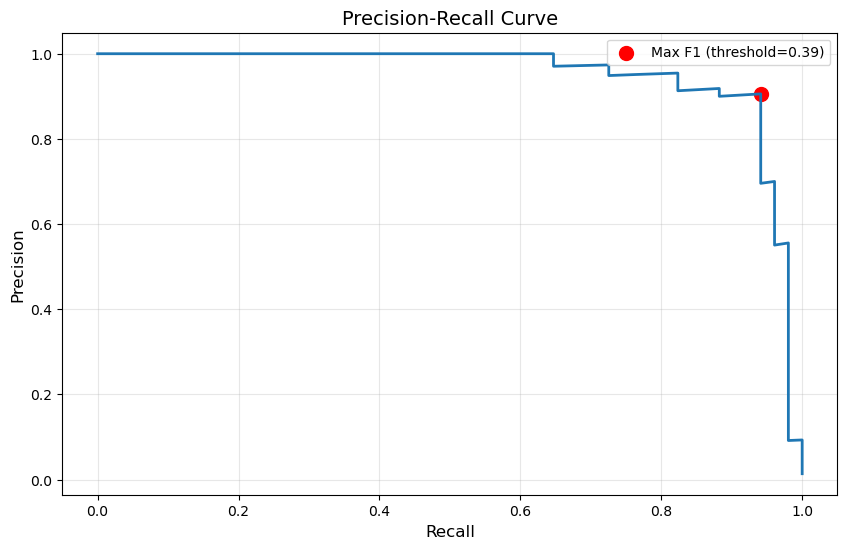

In [36]:
from sklearn.metrics import precision_recall_curve

# Collect predictions across all folds
all_y_true = []
all_y_prob = []
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

for train_idx, test_idx in sgkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    pipe_xgb.fit(X_train, y_train)
    y_prob = pipe_xgb.predict_proba(X_test)[:, 1]

    all_y_true.extend(y_test)
    all_y_prob.extend(y_prob)

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(all_y_true, all_y_prob)

# Maximize F1 (balanced)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx_f1 = np.argmax(f1_scores)
threshold_f1 = thresholds[optimal_idx_f1]
print(f"Threshold for max F1: {threshold_f1:.3f}")
print(f"F1: {f1_scores[optimal_idx_f1]:.3f}")
print(f"Precision: {precisions[optimal_idx_f1]:.3f}")
print(f"Recall: {recalls[optimal_idx_f1]:.3f}")


# Plot precision-recall curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, linewidth=2)
plt.scatter([recalls[optimal_idx_f1]], [precisions[optimal_idx_f1]], 
            color='red', s=100, label=f'Max F1 (threshold={threshold_f1:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')